In [1]:
import quippy
import numpy as np
import API_quippy_phonopy_VASP as api_qpv
from phonopy import Phonopy
import phonopy.interface.vasp as Intf_vasp
import phonopy.file_IO as PhonIO
from phonopy.interface.calculator import get_default_physical_units
from phonopy.units import Epsilon0, EV, AMU, THzToCm
import matplotlib.pyplot as plt
from phonopy.structure.symmetry import symmetrize_borns_and_epsilon

In [2]:
# calculate Born effective charge from the potential. 
Unit_cell = Intf_vasp.read_vasp("POSCAR")
prim_mat = np.eye(3) # specify primitive cell
gp_xml_file = 'soap_n12l11_6.0cut_coul/gp_NaCl_soap_coul.xml'

Freq_BTE_file = 'BTE.omega'
Rate_scatt_file = 'BTE.w_final'

omega_q = np.loadtxt(Freq_BTE_file) # the first row is at q=0, but q->0 point should be used.
Nq,Ns = np.shape(omega_q)
DT_rate = np.loadtxt(Rate_scatt_file)
rate_scatter = np.reshape(DT_rate[:,1],(Nq,Ns),'F')
gamma_to_q0 = rate_scatter[1,:]
print(gamma_to_q0)

[ 0.11065293  0.10952321  0.01941417  0.48918546  0.5003044  -0.13779146]


In [3]:
Ncells=[4,4,4]
q_near_Gamma=[1e-4,0,0]
qmesh=[15,15,15] # set the same as mesh used for ShengBTE
NAC = True
interface_mode = 'vasp'

phonon_scell = Phonopy(Unit_cell,np.diag(Ncells),primitive_matrix=prim_mat) # generate an phononpy object for LD calc.
phonon_scell.generate_displacements(distance=0.03) # vasp
Scells_phonopy = phonon_scell.get_supercells_with_displacements() # This returns a list of Phononpy atoms object
Scells_quippy=[]
for scell in Scells_phonopy:
    Scells_quippy.append(api_qpv.phonopyAtoms_to_aseAtoms(scell))

force_gap_scells = api_qpv.calc_force_sets_GAP(gp_xml_file,Scells_quippy)

phonon_scell.set_forces(force_gap_scells)
PhonIO.write_FORCE_SETS(phonon_scell.get_displacement_dataset()) # write forces & displacements to FORCE_SET
force_set=PhonIO.parse_FORCE_SETS() # parse force_sets
phonon_scell.set_displacement_dataset(force_set) # force_set is a list of forces and displacements


if NAC == True:
    nac_params = PhonIO.get_born_parameters(
            open("BORN"),
            phonon_scell.get_primitive(),
            phonon_scell.get_primitive_symmetry())
    if nac_params['factor'] == None:
        physical_units = get_default_physical_units(interface_mode)
        nac_params['factor'] = physical_units['nac_factor']
    phonon_scell.set_nac_params(nac_params=nac_params)


phonon_scell.produce_force_constants()
phonon_scell.symmetrize_force_constants()
#api_qpv.write_ShengBTE_FC2(phonon_scell.get_force_constants(), filename='FORCE_CONSTANTS_2ND')
phonon_scell.set_mesh(qmesh, is_gamma_center=False, is_eigenvectors=True)
# First get acoustic modes
Zij_b = phonon_scell._dynamical_matrix.get_born_effective_charges()
epsilon_infty = phonon_scell._dynamical_matrix.get_dielectric_constant()

freq_qto0,ebs_qto0 = api_qpv.get_freq_reshaped_eigvec_atq(phonon_scell,q_near_Gamma) 
# frequency is obtained at some q point close to Gamma. 
freq_q0,ebs_q0 = api_qpv.get_freq_reshaped_eigvec_atq(phonon_scell,[0,0,0])
ebs_q0 = np.real(ebs_q0)
# Now take the first q point close to Gamma point 

In [4]:
# Calculate Dynamical charges
Ns,Nb,DIM = np.shape(ebs_q0)
masses = phonon_scell.get_primitive().get_masses()

Z_dyn = np.zeros((Ns,DIM))
for mode in range(Ns):
    for b in range(Nb):
        Z_dyn[mode,:] += np.matmul(Zij_b[b,:,:],ebs_q0[mode,b,:])*np.sqrt(masses[b])

Vol = phonon_scell.get_primitive().get_volume() # Volume of Primitive cell
unit_conversion = phonon_scell._dynamical_matrix._unit_conversion
prefactor = unit_conversion*np.pi*4/Vol #EV**2/Epsilon0/(Vol*1e-30)/AMU

In [5]:
freq_max = np.max(freq_qto0)
freq = np.linspace(0,2*freq_max,101)
omega = 2*np.pi*freq*1e12
Nomega = np.size(omega)
epsilon_ij = np.zeros((Nomega,DIM,DIM),dtype='complex')
epsilon_freq = np.zeros(Nomega,dtype='complex')
n_complex = np.zeros(Nomega,dtype='complex')
R = np.zeros(Nomega)
#for w,iw in enumerate(omega):
for iw,f in enumerate(freq):
    for mode,fs in enumerate(freq_q0):
        if fs>1e-4 and fs<freq_max:
            #ws = fs*2*np.PI*1e12
            gamma_mode = gamma_to_q0[mode]
            epsilon_ij[iw,:,:]=epsilon_infty+prefactor*np.outer(Z_dyn[mode,:],Z_dyn[mode,:])/(fs**2-f**2-1j*gamma_mode*f)
    Z_ij_b,epsilon_ij[iw,:,:] = symmetrize_borns_and_epsilon(Zij_b,epsilon_ij[iw,:,:],Unit_cell)
    epsilon_freq[iw] = np.trace(epsilon_ij[iw,:,:])/3.0

n_complex = np.sqrt(epsilon_freq)
R = np.abs((n_complex-1)/(n_complex+1))**2

Text(0, 0.5, 'Dielectric function')

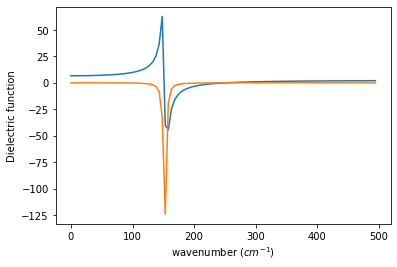

In [6]:
wavenumber = freq*THzToCm
plt.plot(wavenumber,np.real(epsilon_freq))
plt.plot(wavenumber,np.imag(epsilon_freq))
plt.xlabel('wavenumber ($cm^{-1}$)')
plt.ylabel('Dielectric function')

Text(0, 0.5, 'n and $\\kappa$')

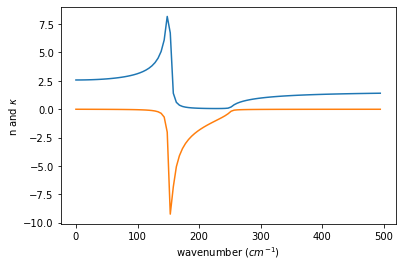

In [7]:
plt.plot(wavenumber,np.real(n_complex))
plt.plot(wavenumber,np.imag(n_complex))
plt.xlabel('wavenumber ($cm^{-1}$)')
plt.ylabel('n and $\kappa$')

(0.0, 1.0)

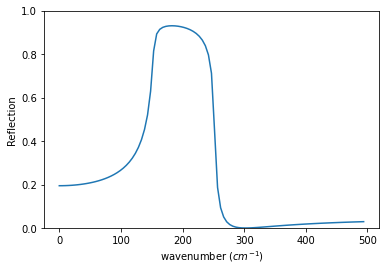

In [8]:
plt.plot(wavenumber,R)
plt.xlabel('wavenumber ($cm^{-1}$)')
plt.ylabel('Reflection')
plt.ylim([0,1])

In [9]:
api_qpv.write_2D_array('Real_Dielectric.dat',np.array([wavenumber,np.real(epsilon_freq)]))
api_qpv.write_2D_array('Imag_Dielectric.dat',np.array([wavenumber,np.imag(epsilon_freq)]))
api_qpv.write_2D_array('Reflection.dat',np.array([wavenumber,R]))